# Single-cell RNA-seq analysis workflow for 1.3 M cells using Scanpy on CPU

Copyright (c) 2020, NVIDIA CORPORATION.
Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

## Import requirements

In [1]:
import time

import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.cluster import KMeans

import os, wget

import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')

## Input data

In [2]:
# Add path to input file here.
input_file = "../data/1M_brain_cells_10X.sparse.h5ad"

if not os.path.exists(input_file):
    print('Downloading import file...')
    os.makedirs('../data', exist_ok=True)
    wget.download('https://rapids-single-cell-examples.s3.us-east-2.amazonaws.com/1M_brain_cells_10X.sparse.h5ad',
              input_file)

## Set parameters

In [3]:
# marker genes
MITO_GENE_PREFIX = "mt-" # Prefix for mitochondrial genes to regress out
markers = ["Stmn2", "Hes1", "Olig1"] # Marker genes for visualization

# filtering cells
min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed 

# filtering genes
min_cells_per_gene = 1 # Filter out genes expressed in fewer cells than this
n_top_genes = 4000 # Number of highly variable genes to retain

# PCA
n_components = 50 # Number of principal components to compute

# t-SNE
tsne_n_pcs = 20 # Number of principal components to use for t-SNE

# k-means
k = 35 # Number of clusters for k-means

# KNN
n_neighbors = 15 # Number of nearest neighbors for KNN graph
knn_n_pcs = 50 # Number of principal components to use for finding nearest neighbors

# UMAP
umap_min_dist = 0.3 
umap_spread = 1.0

# Gene ranking
ranking_n_top_genes = 50 # Number of differential genes to compute for each cluster

# Number of parallel jobs
sc._settings.ScanpyConfig.n_jobs = 40

In [4]:
start = time.time()

## Load and Prepare Data

In [5]:
%%time
adata = sc.read(input_file)
adata.var_names_make_unique()
adata.shape

CPU times: user 1min 12s, sys: 9.74 s, total: 1min 22s
Wall time: 1min 25s


(1306127, 27998)

In [6]:
# To reduce the number of cells: 
USE_FIRST_N_CELLS = 1300000
adata = adata[0:USE_FIRST_N_CELLS]
adata.shape

(1300000, 27998)

## Preprocessing

In [7]:
preprocess_start = time.time()

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

In [8]:
%%time
sc.pp.filter_cells(adata, min_genes=min_genes_per_cell)
sc.pp.filter_cells(adata, max_genes=max_genes_per_cell)

CPU times: user 4min 15s, sys: 1min 29s, total: 5min 44s
Wall time: 5min 44s


Some genes will now have zero expression in all cells. We filter out such genes.

In [9]:
%%time
sc.pp.filter_genes(adata, min_cells=min_cells_per_gene)

CPU times: user 1min 1s, sys: 22.1 s, total: 1min 23s
Wall time: 1min 23s


In [10]:
adata.shape

(1285302, 23992)

### Normalize

In [11]:
%%time
sc.pp.normalize_total(adata, target_sum=1e4)

CPU times: user 9.81 s, sys: 2.39 s, total: 12.2 s
Wall time: 12.2 s


In [12]:
%%time
sc.pp.log1p(adata)

CPU times: user 30.6 s, sys: 14 ms, total: 30.6 s
Wall time: 30.6 s


### Select Most Variable Genes

In [13]:
%%time

# Select highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes, flavor = "cell_ranger")

# Retain marker gene expression
for marker in markers:
    adata.obs[marker + "_raw"] = adata.X[:, adata.var.index == marker].toarray().ravel()

# Filter matrix to only variable genes
adata = adata[:, adata.var.highly_variable]

CPU times: user 44.6 s, sys: 312 ms, total: 44.9 s
Wall time: 45 s


### Regress out confounding factors (number of counts, mitochondrial gene expression)

In [14]:
%%time
mito_genes = adata.var_names.str.startswith(MITO_GENE_PREFIX)
n_counts = np.array(adata.X.sum(axis=1))
adata.obs['percent_mito'] = np.array(np.sum(adata[:, mito_genes].X, axis=1)) / n_counts
adata.obs['n_counts'] = n_counts

CPU times: user 35.2 s, sys: 2.74 s, total: 37.9 s
Wall time: 37.9 s


In [15]:
%%time
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

CPU times: user 5min 22s, sys: 3min 54s, total: 9min 16s
Wall time: 8min 57s


### Scale

In [16]:
%%time
sc.pp.scale(adata, max_value=10)

CPU times: user 47.6 s, sys: 5.48 s, total: 53 s
Wall time: 53 s


In [17]:
preprocess_time = time.time()
print("Total Preprocess time : %s" % (preprocess_time-preprocess_start))

Total Preprocess time : 1143.77796626091


## Cluster & Visualize

### Reduce

We use PCA to reduce the dimensionality of the matrix to its top 50 principal components.

In [18]:
%%time
sc.tl.pca(adata, n_comps=n_components)

CPU times: user 3h 19min 53s, sys: 13min 6s, total: 3h 33min
Wall time: 3min 23s


### TSNE + K-means

In [19]:
%%time
sc.tl.tsne(adata, n_pcs=tsne_n_pcs, use_fast_tsne=True)

CPU times: user 8h 1min 55s, sys: 5min 35s, total: 8h 7min 30s
Wall time: 1h 42min 30s


In [20]:
%%time
kmeans = KMeans(n_clusters=k, random_state=0).fit(adata.obsm['X_pca'])
adata.obs['kmeans'] = kmeans.labels_.astype(str)

CPU times: user 2h 57min 2s, sys: 2h 22min 43s, total: 5h 19min 45s
Wall time: 5min 4s


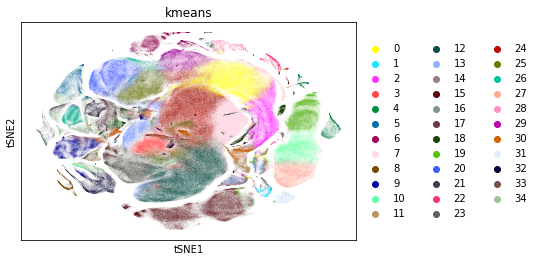

CPU times: user 6.15 s, sys: 1.11 s, total: 7.26 s
Wall time: 7.02 s


In [21]:
%%time
sc.pl.tsne(adata, color=["kmeans"])

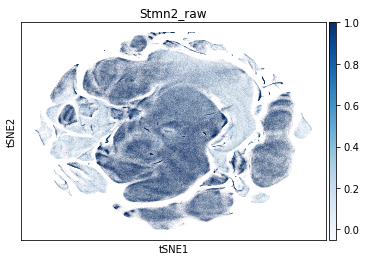

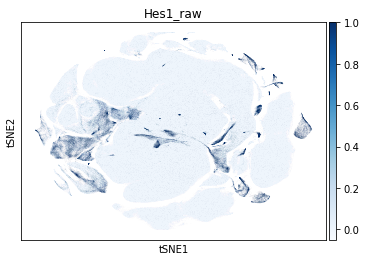

CPU times: user 6.88 s, sys: 276 ms, total: 7.16 s
Wall time: 6.66 s


In [22]:
%%time
sc.pl.tsne(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.tsne(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

### UMAP + Graph clustering

In [23]:
%%time
# KNN graph
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)

CPU times: user 28min 5s, sys: 39min 15s, total: 1h 7min 21s
Wall time: 2min 25s


In [24]:
%%time
# UMAP
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)

CPU times: user 15h 19min 18s, sys: 2h 30min 55s, total: 17h 50min 13s
Wall time: 37min 41s


In [25]:
%%time
# Louvain clustering
sc.tl.louvain(adata)

CPU times: user 16min 36s, sys: 6.01 s, total: 16min 42s
Wall time: 16min 40s


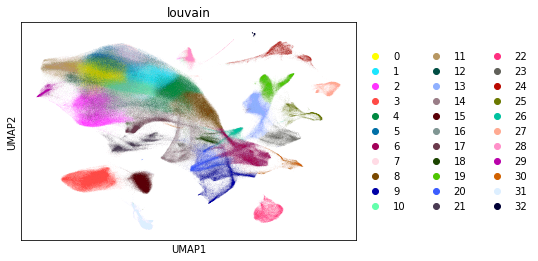

CPU times: user 6.04 s, sys: 257 ms, total: 6.3 s
Wall time: 6.05 s


In [26]:
%%time
sc.pl.umap(adata, color=["louvain"])

In [27]:
%%time
# Leiden clustering
sc.tl.leiden(adata)

CPU times: user 1h 9min 42s, sys: 2min 12s, total: 1h 11min 55s
Wall time: 1h 11min 45s


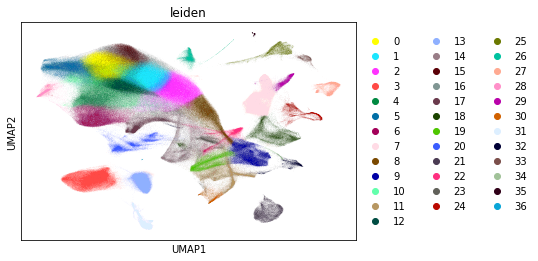

CPU times: user 6.08 s, sys: 244 ms, total: 6.33 s
Wall time: 6.08 s


In [28]:
%%time
sc.pl.umap(adata, color=["leiden"])

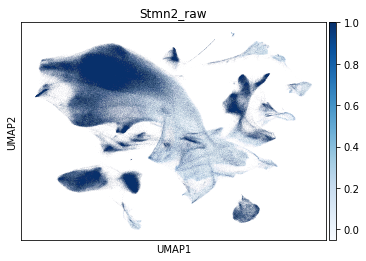

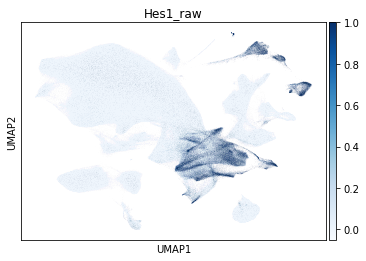

CPU times: user 7.04 s, sys: 255 ms, total: 7.29 s
Wall time: 6.8 s


In [29]:
%%time
sc.pl.umap(adata, color=["Stmn2_raw"], color_map="Blues", vmax=1, vmin=-0.05)
sc.pl.umap(adata, color=["Hes1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

## Differential expression analysis

In [30]:
%%time
sc.tl.rank_genes_groups(adata, groupby="louvain", n_genes=50, groups='all', reference='rest', method='logreg')

CPU times: user 17h 40min, sys: 2h 12min 14s, total: 19h 52min 14s
Wall time: 20min 12s


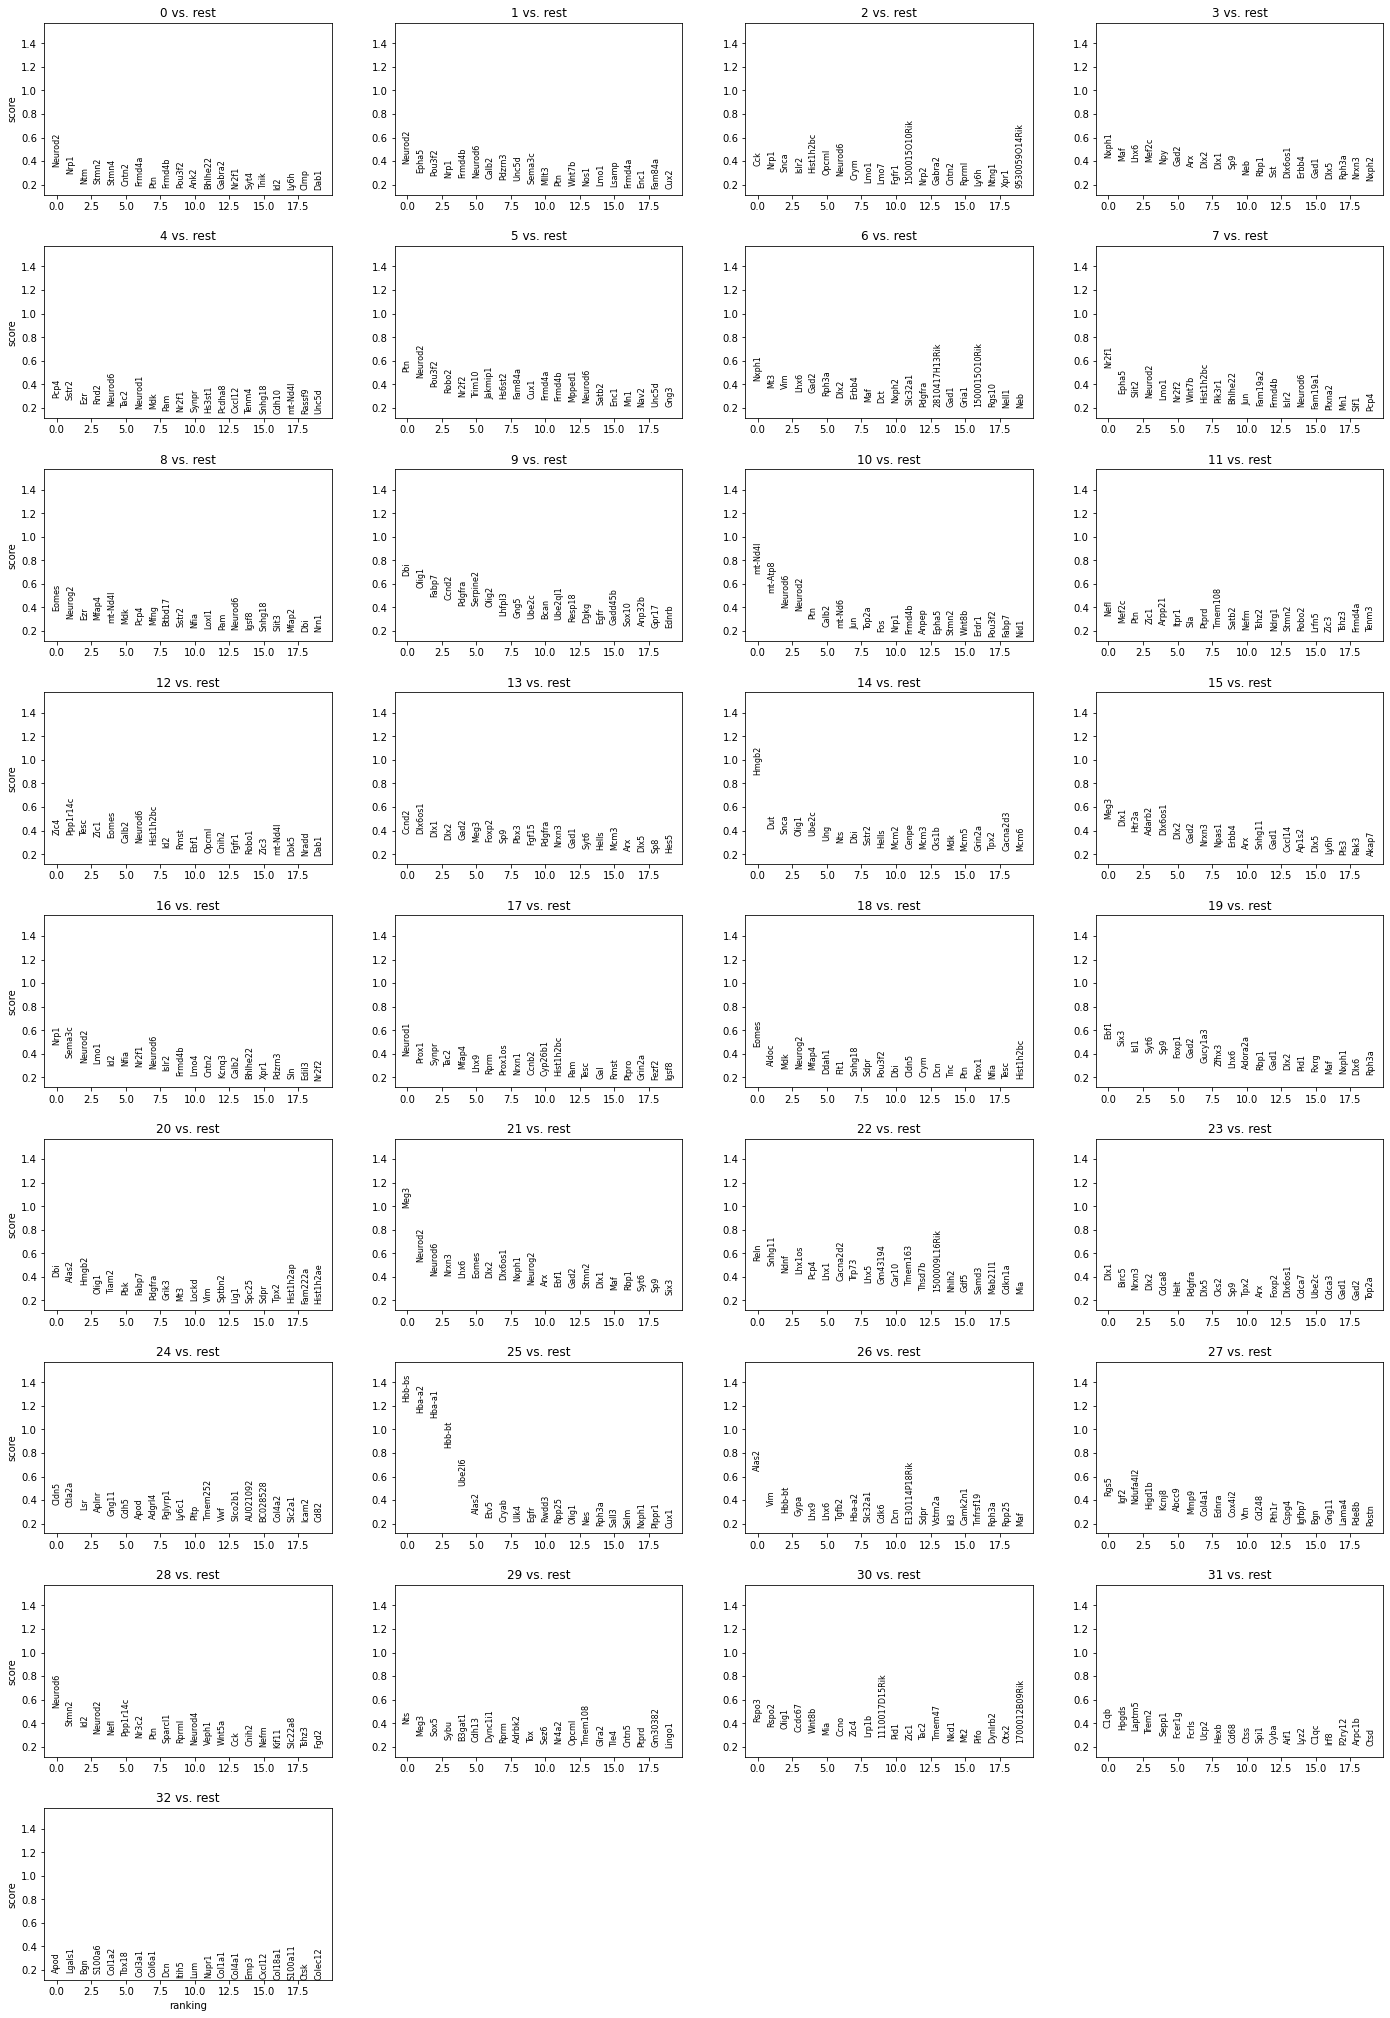

CPU times: user 5.35 s, sys: 2.91 s, total: 8.25 s
Wall time: 8.01 s


In [31]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

## Create Zoomed View

The speedup offered by Rapids makes it easy to interactively re-analyze subsets of cells. To illustrate this, we select epithelial cells (EPCAM+) from the dataset.

In [32]:
reanalysis_start = time.time()

In [33]:
%%time
hes1_cells = adata.obs["Hes1_raw"] > 0.0
adata = adata[hes1_cells,:]
adata.shape

CPU times: user 33.8 ms, sys: 10.3 ms, total: 44 ms
Wall time: 43.4 ms


(119794, 4000)

We can repeat the dimension reduction, clustering and visualization using this subset of cells in seconds.

In [34]:
%%time
sc.tl.pca(adata, n_comps=n_components)
sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=knn_n_pcs)
sc.tl.umap(adata, min_dist=umap_min_dist, spread=umap_spread)
sc.tl.leiden(adata)

CPU times: user 46min 10s, sys: 13min 14s, total: 59min 24s
Wall time: 3min 36s


And plot the results:

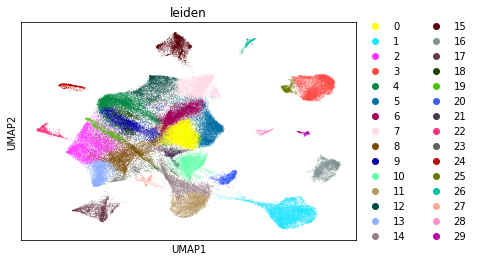

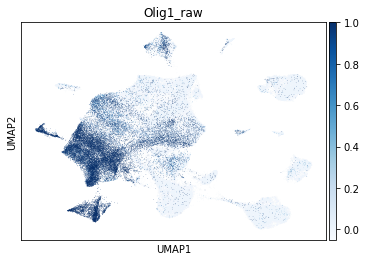

CPU times: user 1.75 s, sys: 321 ms, total: 2.07 s
Wall time: 1.58 s


In [35]:
%%time
sc.pl.umap(adata, color=["leiden"])
sc.pl.umap(adata, color=["Olig1_raw"], color_map="Blues", vmax=1, vmin=-0.05)

In [36]:
reanalysis_time = time.time()
print("Total reanalysis time : %s" % (reanalysis_time-reanalysis_start))

Total reanalysis time : 217.67653822898865


In [37]:
print("Full time: %s" % (time.time() - start))

Full time: 17071.51189470291
